# Accelerating Cleantech Advancements through NLP-Powered Text Mining and Knowledge Extraction

Group: Marusa Storman, Vignesh Govindaraj, Pradip Ravichandran

## Stage 3: Developing Advanced Question Answering and/or Information Retrieval System

### Preparing

In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.getcwd()

# Change current working directory to where the notebook resides
os.chdir(notebook_dir)

# List of required libraries
required_libraries = [
    'bert-extractive-summarizer',
    'matplotlib',
    'nltk',
    'numpy',
    'pandas',
    'pinecone-client', # set the sentence embedding database with pine-client
    're',
    'requests',
    #'spacy',
    'seaborn',
    'sentencepiece',
    'sentence-transformers', # https://huggingface.co/sentence-transformers
    'string',
    'textblob',
    'tensorflow',
    'transformers',
    'tf-keras'
]

# Check if each library is installed, if not, install it
for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        print(f"Installing {lib}...")
        !"{sys.executable}" -m pip install {lib}

Installing bert-extractive-summarizer...


Installing pinecone-client...


Installing sentence-transformers...


Installing tf-keras...


In [2]:
# import the packages.
import ast # convert the string to a list using the ast module
import datetime
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import re
import requests
import seaborn as sns
# import spacy
import string
import tensorflow as tf
import time
import torch
import zipfile

from pathlib import Path
from sentence_transformers import SentenceTransformer
from summarizer import Summarizer
from textblob import TextBlob
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup
from transformers import pipeline
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


# Jupyter config
%config InteractiveShell.ast_node_interactivity = 'all'

# Additional setup for seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

# Download needed NLTK's resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pradip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df3 = pd.read_csv("Data/ct_media_clean.csv")
df3.head()

,title,date,author,content,domain,url
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,Qatar Petroleum (QP) is targeting aggressive c...,energyintel,0000017b-a7dc-de4c-a17b-e7de685b0000
1,India Launches Its First 700 MW PHWR,2021-01-15,NaN,• Nuclear Power Corp. of India Ltd. (NPCIL) sy...,energyintel,0000017b-a7dc-de4c-a17b-e7de6c710001
2,New Chapter for US-China Energy Trade,2021-01-20,NaN,New US President Joe Biden took office this we...,energyintel,0000017b-a7dc-de4c-a17b-e7de735a0000
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,The slow pace of Japanese reactor restarts con...,energyintel,0000017b-a7dc-de4c-a17b-e7de79160000
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,Two of New York City's largest pension funds s...,energyintel,0000017b-a7dc-de4c-a17b-e7de7d9e0000


In [4]:
#removing unused columns 
df3.drop(['author','domain','url'], axis=1, inplace=True)

# removing html tags
df3['content'] = df3['content'].apply(lambda x: re.sub('<[^<]+?>', '', x))

# Remove duplicates
df3.drop_duplicates(subset='content', keep='first', inplace=True)

## Newlines, spaces and tabs removal
df3['content'] = df3['content'].apply(lambda x: re.sub('\s+', ' ', x))


df3.info()
df3.head()

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Pradip\AppData\Local\Temp\ipykernel_9968\1364746538.py:11: SyntaxWarning: invalid escape sequence '\s'
  df3['content'] = df3['content'].apply(lambda x: re.sub('\s+', ' ', x))


<class 'pandas.core.frame.DataFrame'>
Index: 9588 entries, 0 to 9592
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    9588 non-null   object
 1   date     9588 non-null   object
 2   content  9588 non-null   object
dtypes: object(3)
memory usage: 299.6+ KB


,title,date,content
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,Qatar Petroleum (QP) is targeting aggressive c...
1,India Launches Its First 700 MW PHWR,2021-01-15,• Nuclear Power Corp. of India Ltd. (NPCIL) sy...
2,New Chapter for US-China Energy Trade,2021-01-20,New US President Joe Biden took office this we...
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,The slow pace of Japanese reactor restarts con...
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,Two of New York City's largest pension funds s...


In [5]:
# extract Keywords
model = Summarizer()
result = model(df3['content'][0], min_length=60)
result

"Qatar Petroleum (QP) is targeting aggressive cuts in its greenhouse gas emissions as it prepares to launch Phase 2 of its planned 48 million ton per year LNG expansion. But QP judged them to be too expensive and none met its targeted 50-week construction schedule. Shortlisted contractors were asked to look for cost savings and submit new bids. But the shortlisted companies are expected to bid aggressively for what is expected to be the world's lowest-cost and most environmentally friendly LNG (LNGI Nov.9'20)."

In [6]:
df3['content'][0]

"Qatar Petroleum (QP) is targeting aggressive cuts in its greenhouse gas emissions as it prepares to launch Phase 2 of its planned 48 million ton per year LNG expansion. In its latest Sustainability Report published on Wednesday, QP said its goals include `` reducing the emissions intensity of Qatar's LNG facilities by 25% and of its upstream facilities by at least 15%. '' The company is also aiming to reduce gas flaring intensity across its upstream facilities by more than 75% and has raised its carbon capture and storage ambitions from 5 million tons/yr to 7 million tons/yr by 2027. About 2.2 million tons/yr of the carbon capture goal will come from the 32 million ton/yr Phase 1 of the LNG expansion, also known as the North Field East project. A further 1.1 million tons/yr will come from Phase 2, known as the North Field South project, which will raise Qatar's LNG capacity by a further 16 million tons/yr. Qatar currently has an LNG production capacity of around 78 million tons/yr and

In [7]:
# using the last 50 rows
n=50

df_last_50 = df3[-n:]

# extract the ke sentences
df_last_50['key_sentences'] = df_last_50['content'].apply(lambda x: model(x,min_length=30))

print(f'the last {n} key sentense finished!')

the last 50 key sentense finished!


C:\Users\Pradip\AppData\Local\Temp\ipykernel_9968\1178133710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_50['key_sentences'] = df_last_50['content'].apply(lambda x: model(x,min_length=30))


In [8]:
# Save the DataFrame to a CSV file
df_last_50.to_csv(f"Data/last_50_output.csv", index=False)

In [9]:
df_last_50['content'][9552]

'Nextracker, a solar tracker and software solutions company, and Unimacts, a provider of industrial manufacturing and supply chain solutions, have opened a Nextracker-dedicated manufacturing facility in Las Vegas. Owned and operated by Unimacts, the facility will produce critical steel components exclusively for Nextracker used in ground-mount solar power generation plants to primarily serve projects in Nevada and southwestern states. This is Nextracker’ s sixth public dedication of a new manufacturing facility since 2022 and the 15th facility it opened or expanded with key suppliers in the United States in that time. The Las Vegas facility features expanded production capacity generating more than 100 new jobs currently and over 200 expected by 2024. The plant includes Unimacts manufacturing machinery and equipment relocated from Mexico as well as new equipment. According to the Solar Energy Industries Association (SEIA), nearly 200 GW of solar manufacturing capacity have been announc

In [10]:
df_last_50['key_sentences'][9552]

'Nextracker, a solar tracker and software solutions company, and Unimacts, a provider of industrial manufacturing and supply chain solutions, have opened a Nextracker-dedicated manufacturing facility in Las Vegas. The plant includes Unimacts manufacturing machinery and equipment relocated from Mexico as well as new equipment. Unimacts is excited that our partnership with Nextracker will create new jobs and increase the amount of solar we can produce here in the U.S., ” says Matt Arnold, CEO of Unimacts. “'

### Generating Questions and Answers

In [11]:
# Inspect the data frame
df_last_50 = pd.read_csv("Data/last_50_output.csv")

# Remove unused coloumns
df_last_50.drop(['title','date'], axis=1, inplace=True)
df_last_50

,content,key_sentences
0,"Anza, a solar and energy storage procurement p...","Anza, a solar and energy storage procurement p..."
1,Solar solutions provider Nextracker is set to ...,Solar solutions provider Nextracker is set to ...
2,"Ampt, a DC optimizer company focusing on large...","Ampt, a DC optimizer company focusing on large..."
3,"Ampion Renewable Energy, a provider of communi...","Ampion Renewable Energy, a provider of communi..."
4,Solar investment funder and manager NT Solar i...,Solar investment funder and manager NT Solar i...
5,"Redeux Energy Partners LLC, a utility-scale so...","Redeux Energy Partners LLC, a utility-scale so..."
6,"Monarch Private Capital, an investment firm th...","Monarch Private Capital, an investment firm th..."
7,"Catalyze, a clean energy transition company th...","Catalyze, a clean energy transition company th..."
8,"Dimension Renewable Energy, a developer and op...","Dimension Renewable Energy, a developer and op..."
9,"Nextracker, a solar tracker and software solut...","Nextracker, a solar tracker and software solut..."


For generating questions we are using transformer model

In [12]:
# Define the path to the ZIP file and the directory to extract to
zip_file_path = Path("qa_generator.zip")
extract_to_path = Path("Data")

# Ensure the paths are valid (this is just for demonstration, adapt to your actual paths)
if not zip_file_path.is_file():
    print(f"ZIP file not found at {zip_file_path}")
else:
    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified directory
        zip_ref.extractall(extract_to_path)

    print(f"Files extracted to {extract_to_path}")


Files extracted to Data


In [13]:
from Data.content.question_generation.pipelines import pipeline as HuggingFacePipe # using https://huggingface.co/valhalla/t5-base-qg-hl

qa_generator = HuggingFacePipe("question-generation", model="valhalla/t5-base-qg-hl")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
# creating an empty list to store questions and answers
text_list = []

# use for loop to generate Q&A
for i, text in enumerate(df_last_50['key_sentences']):
  print(i)
  text_list.append(qa_generator(text))

# SAVE the result to df
df_last_50['QA'] = text_list

0
{'input_ids': tensor([[5819, 4269,   10,  ...,    0,    0,    0],
        [5819, 4269,   10,  ...,    0,    0,    0],
        [5819, 4269,   10,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\transformers\models\t5\tokenization_t5.py:290: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


['<pad> Anza<sep></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>', '<pad> buyers have a tool to see all the technical, financial, supply chain and risk-related data needed to select the best components for their project<sep></s>', '<pad> analytics<sep></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
An exception occurred
1
{'input_ids': tensor([[5819, 4269,   10,  ...,    0,    0,    0],
        [5819, 4269,   10,  ...,    0,    0,    0],
        [5819, 4269,   10,  ...,    0,    0,    0],
        [5819, 4269,   10,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
['<pad> Nextracker<sep></s><pad><pad><pad><pad><pad>', '<pad> four times faster<sep></s><pad><pad><pad><p

In [15]:
# set the content index to check
n = 20

#PRINT THE KEY SENTENC
df_last_50['key_sentences'][n]

#PRINT THE QA
df_last_50['QA'][n]

'Enel North America has signed a power purchase agreement with BXP, the largest publicly traded developer, owner and manager of premier workplaces in the United States, for a 21 MW portion of the Estonian solar project under construction in Delta County, Texas. “ Enel offers companies a variety of tools to manage energy efficiently and lower their carbon footprint – from clean power contracts to load-side solutions like demand response, ” says Paolo Romanacci, head Enel Green Power North America. “ Enel is one of the largest renewable energy operators in Texas, with 3.3 GW of installed wind and solar capacity and 607 MW/911 MWh of installed battery storage capacity supporting the ERCOT grid.'

[{'answer': '21 MW',
  'question': 'How large is the portion of the Estonian solar project that Enel North America has signed a power purchase agreement with BXP?'},
 {'answer': 'BXP',
  'question': 'Who is the largest publicly traded developer, owner and manager of premier workplaces in the US?'},
 {'answer': 'Enel Green Power North America',
  'question': "What is Paolo Romanacci's job title?"},
 {'answer': '607 MW/911 MWh',
  'question': 'How much battery storage capacity does Enel have?'}]

In [16]:
# save the stage to csv
df_last_50.to_csv(f"Data/last_50_QA.csv")

### Cleaning generated QA pairs 

In [17]:
# load the stage data
data_folder = Path("Data")
df_qa = pd.read_csv(data_folder / "last_50_QA.csv")
# rename the column
df_qa = df_qa.rename(columns={"Unnamed: 0": "idx", "key_sentences": "summary",})
# select the usful column
df_qa = df_qa.iloc[:, [0,2,3]]

df_qa.keys()

Index(['idx', 'summary', 'QA'], dtype='object')

In [18]:
# Initialize an empty DataFrame
df_QA_clean = pd.DataFrame({'summary': [], 'Q': [], 'A': []})

# Iterate over the rows in the DataFrame
for i in df_qa.index:
    # Convert the string representation of a list to a list of dictionaries
    qa_list = ast.literal_eval(df_qa['QA'].iloc[i])

    for key_s in qa_list:
        if "'" in key_s['answer']:
            continue
        else:
            # Create a new DataFrame with the new row
            new_row = pd.DataFrame({
                "summary": [df_qa["summary"].iloc[i]],
                "Q": [key_s['question']],
                "A": [key_s['answer']]
            })
            # Concatenate the new row to the clean DataFrame
            df_QA_clean = pd.concat([df_QA_clean, new_row], ignore_index=True)

# Display the cleaned DataFrame
df_QA_clean

,summary,Q,A
0,"Anza, a solar and energy storage procurement p...",What is the name of the solar and energy stora...,Anza
1,"Anza, a solar and energy storage procurement p...",What does Anza's technology provide?,analytics
2,Solar solutions provider Nextracker is set to ...,Which solar solutions provider is set to launc...,Nextracker
3,Solar solutions provider Nextracker is set to ...,How much faster can NX Horizon stow than stand...,four times faster
4,Solar solutions provider Nextracker is set to ...,What is Nextracker's latest innovation for hil...,NX Horizon XTR-1.5
...,...,...,...
187,Once the self-proclaimed “ leading renewable p...,What may serve as a cautionary tale for the in...,rapid rise and fall
188,Arevon Energy Inc. has closed financing on the...,Who closed financing on the Vikings solar-plus...,Arevon Energy Inc.
189,Arevon Energy Inc. has closed financing on the...,Who participated as a lender on the Vikings so...,National Bank of Canada
190,Arevon Energy Inc. has closed financing on the...,Which company is supplying the Vikings solar-p...,Tesla


In [19]:
# save the stage to csv
df_QA_clean.to_csv(f"Data/last_50_QA_clean.csv")

### fine-tune GPT-2


In [20]:
from torch.utils.data import Dataset, random_split

torch.manual_seed(50)

In [21]:
# Check if GPU is available and use CPU if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example tensor creation
x = torch.tensor([1, 2, 3], device=device)
print(x)


tensor([1, 2, 3])


In [22]:
# loading into data frame
df = pd.read_csv("Data/last_50_QA_clean.csv")
df.head()

,Unnamed: 0,summary,Q,A
0,0,"Anza, a solar and energy storage procurement p...",What is the name of the solar and energy stora...,Anza
1,1,"Anza, a solar and energy storage procurement p...",What does Anza's technology provide?,analytics
2,2,Solar solutions provider Nextracker is set to ...,Which solar solutions provider is set to launc...,Nextracker
3,3,Solar solutions provider Nextracker is set to ...,How much faster can NX Horizon stow than stand...,four times faster
4,4,Solar solutions provider Nextracker is set to ...,What is Nextracker's latest innovation for hil...,NX Horizon XTR-1.5


In [23]:
# Disable CPU usage
tf.config.set_visible_devices([], 'cpu')

# Example tensor creation
x = tf.constant([1, 2, 3])
print(x)


tf.Tensor([1 2 3], shape=(3,), dtype=int32)


In [24]:
# For calculation max token length
test_Q = df.Q.copy()
test_A = df.A.copy()
test_Q
test_A

0      What is the name of the solar and energy stora...
1                   What does Anza's technology provide?
2      Which solar solutions provider is set to launc...
3      How much faster can NX Horizon stow than stand...
4      What is Nextracker's latest innovation for hil...
                             ...                        
187    What may serve as a cautionary tale for the in...
188    Who closed financing on the Vikings solar-plus...
189    Who participated as a lender on the Vikings so...
190    Which company is supplying the Vikings solar-p...
191                  Where is Nextracker's headquarters?
Name: Q, Length: 192, dtype: object

0                         Anza
1                    analytics
2                   Nextracker
3            four times faster
4           NX Horizon XTR-1.5
                ...           
187        rapid rise and fall
188         Arevon Energy Inc.
189    National Bank of Canada
190                      Tesla
191             Fremont, Calif
Name: A, Length: 192, dtype: object

Max length of tokens in answers: 22
Max length of tokens in questions: 26


C:\Users\Pradip\AppData\Local\Temp\ipykernel_9968\1788390642.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([len(nltk.word_tokenize(text)) for text in test_A], kde=False, bins=20, label="Answers")


<Axes: >

C:\Users\Pradip\AppData\Local\Temp\ipykernel_9968\1788390642.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([len(nltk.word_tokenize(text)) for text in test_Q], kde=False, bins=20, label="Questions")


<Axes: >

Text(0.5, 1.0, 'Density of Token Lengths')

Text(0.5, 0, 'Token Length')

Text(0, 0.5, 'Frequency')

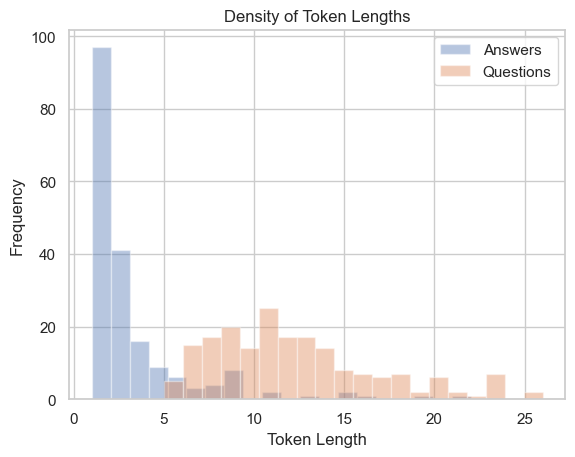

In [25]:
# Calculate the max length of tokens in answers
lengths_ans = [len(nltk.word_tokenize(text)) for text in test_A]
max_length_A = max(lengths_ans)

# Calculate the max length of tokens in questions
lengths_ques = [len(nltk.word_tokenize(text)) for text in test_Q]
max_length_Q = max(lengths_ques)

print("Max length of tokens in answers:", max_length_A)
print("Max length of tokens in questions:", max_length_Q)

# Plot the density of token lengths in answers
sns.distplot([len(nltk.word_tokenize(text)) for text in test_A], kde=False, bins=20, label="Answers")
sns.distplot([len(nltk.word_tokenize(text)) for text in test_Q], kde=False, bins=20, label="Questions")
plt.title("Density of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

C:\Users\Pradip\AppData\Local\Temp\ipykernel_9968\2500927374.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(lengths_ans, shade=True, label='Answer Lengths')


<Axes: ylabel='Density'>

C:\Users\Pradip\AppData\Local\Temp\ipykernel_9968\2500927374.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(lengths_ques, shade=True, label='Question Lengths')


<Axes: ylabel='Density'>

Text(0.5, 1.0, 'KDE Plot of Token Lengths')

Text(0.5, 0, 'Token Length')

Text(0, 0.5, 'Density')

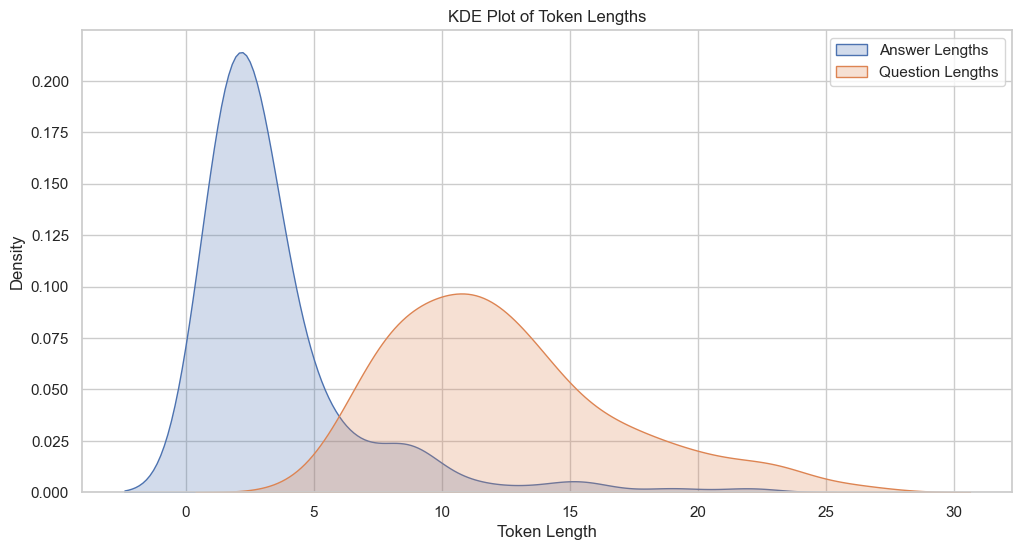

In [26]:
plt.figure(figsize=(12, 6))
sns.kdeplot(lengths_ans, shade=True, label='Answer Lengths')
sns.kdeplot(lengths_ques, shade=True, label='Question Lengths')
plt.title('KDE Plot of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()


In [27]:
print(max_length_A + max_length_Q)
print(np.average(lengths_ques))

48
12.401041666666666


#### GPT2 Tokenizer

In [28]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pradip\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [29]:
print("The max model length is {} for this model, even though the actual embedding size for GPT small is 60".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, even though the actual embedding size for GPT small is 60
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


### PyTorch Datasets & Dataloaders

In [30]:
class GPT2Dataset(Dataset):

  def __init__(self, df_qa, tokenizer, gpt2_type="gpt2", max_length=60):

    self.tokenizer = tokenizer
    self.question_tokens = []
    self.question_masks = []
    self.answer_tokens = []

    for index, row in df_qa.iterrows():

      q_dict = tokenizer('<|startoftext|>'+ '{Question:} ' + row['Q'] + ' {Answer:} ' + row['A']+ '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      self.question_tokens.append(torch.tensor(q_dict['input_ids']))
      self.question_masks.append(torch.tensor(q_dict['attention_mask']))
    
  def __len__(self):
    return len(self.question_tokens)

  def __getitem__(self, idx):
    return self.question_tokens[idx], self.question_masks[idx]

In [31]:
# Create GPT2Dataset object
dataset = GPT2Dataset(df, tokenizer, max_length=60)

# Split into training and validation sets
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


  182 training samples
   10 validation samples


In [33]:
batch_size = 2

# Create DataLoaders for training and validation datasets
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)



Fine Tune GPT2 Model

In [34]:
# Set the configuration
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# This step is necessary because some tokens (bos_token, etc.) have been added to the embeddings
# Otherwise, the tokenizer and model tensors won't match up
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

# Set the device to CPU
device = torch.device("cpu")
model.to(device)

# Set the seed value for reproducibility
seed_val = 20
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50257, 768)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [36]:
learning_rate = 2e-5
epsilon = 1e-8
epochs = 3
warmup_steps = 0

# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [38]:
# Load the tokenizer and model from the same pretrained checkpoint
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Ensure the tokenizer and model have the same vocabulary size
model.resize_token_embeddings(len(tokenizer))


Embedding(50257, 768)

In [39]:
def check_input_ids(data_loader, model):
    for step, batch in enumerate(data_loader):
        b_input_ids = batch[0]
        if (b_input_ids >= model.config.vocab_size).any() or (b_input_ids < 0).any():
            print(f"Out of range token IDs found in batch {step}")
            return step, b_input_ids
    print("All token IDs are within the valid range.")

step, b_input_ids = check_input_ids(train_dataloader, model)
print("Batch with out of range token IDs:", step)
print("Token IDs:", b_input_ids)


Out of range token IDs found in batch 0
Batch with out of range token IDs: 0
Token IDs: tensor([[50257,    90, 24361,    25,    92, 12347,  5756,  1010,    13,   785,
          3557,   689, 13204,  7475,    11,  4708, 11949, 25560,    11,   290,
          1281,    12, 17350,   341,  7475,   329, 12420,  6591,  9988,  2706,
           287,   703,   867,  1294,  1391, 33706,    25,    92,  2026, 50256,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258],
        [50257,    90, 24361,    25,    92,  1374,   867,  3341,   423,   587,
          5884,   284,   262,   955,  7407, 10706,   355,   286,  2693,    30,
          1391, 33706,    25,    92,  1367,    11,   830, 50256, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258

In [40]:
# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Add special tokens if necessary
special_tokens = {'pad_token': '<PAD>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens)
model.resize_token_embeddings(len(tokenizer))

def preprocess_data(text_data, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for text in text_data:
        encoded_data = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Example usage:
train_texts = ["your training text data here"]
train_input_ids, train_attention_masks = preprocess_data(train_texts, tokenizer, max_length=512)


Embedding(50258, 768)

In [41]:
def check_input_ids(data_loader, model):
    for step, batch in enumerate(data_loader):
        b_input_ids = batch[0]
        if (b_input_ids >= model.config.vocab_size).any() or (b_input_ids < 0).any():
            print(f"Out of range token IDs found in batch {step}")
            return step, b_input_ids
    print("All token IDs are within the valid range.")

step, b_input_ids = check_input_ids(train_dataloader, model)
print("Batch with out of range token IDs:", step)
print("Token IDs:", b_input_ids)


Out of range token IDs found in batch 0
Batch with out of range token IDs: 0
Token IDs: tensor([[50257,    90, 24361,    25,    92,  1374,   881,   750,  4285,  1045,
          5985,  6682,  1969,   663, 39350,  8063,   290,  3850,   286,  3884,
          6841,    30,  1391, 33706,    25,    92,   720,  5867,  1510, 50256,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258],
        [50257,    90, 24361,    25,    92,  1867,   318,   262,   649,  6841,
           287,   314,   527,   544, 35240,    11,  4689,    13,  1391, 33706,
            25,    92,  8150,  3938, 31677, 11521,  8860,   287,   262,  1578,
          1829, 50256, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258

In [42]:
from torch.utils.data import TensorDataset

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Add special tokens if necessary
special_tokens = {'pad_token': '<PAD>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens)
model.resize_token_embeddings(len(tokenizer))

# Preprocess function
def preprocess_data(text_data, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for text in text_data:
        encoded_data = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Example training and validation texts
train_texts = ["your training text data here"]
val_texts = ["your validation text data here"]

# Preprocess the training and validation data
train_input_ids, train_attention_masks = preprocess_data(train_texts, tokenizer, max_length=512)
val_input_ids, val_attention_masks = preprocess_data(val_texts, tokenizer, max_length=512)

# Create the DataLoader for training and validation sets
train_dataset = TensorDataset(train_input_ids, train_attention_masks)
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=4
)

val_dataset = TensorDataset(val_input_ids, val_attention_masks)
val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=4
)

# Function to format time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# Initialize the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
total_steps = len(train_dataloader) * 10  # Assuming 10 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
total_t0 = time.time()
training_stats = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
epochs = 10

for epoch_i in range(epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
    print('Training...')
    
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=b_input_ids, attention_mask=b_masks, labels=b_labels)
        loss = outputs.loss
        
        batch_loss = loss.item()
        total_train_loss += batch_loss
        
        if step % 10 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss: {batch_loss}. Elapsed: {elapsed}.')
        
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print(f"Average training loss: {avg_train_loss:.2f}")
    print(f"Training epoch took: {training_time}")

    print("\nRunning Validation...")
    t0 = time.time()
    model.eval()
    total_eval_loss = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=b_input_ids, attention_mask=b_masks, labels=b_labels)
            loss = outputs.loss
        
        total_eval_loss += loss.item()
    
    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = format_time(time.time() - t0)
    print(f"Validation Loss: {avg_val_loss:.2f}")
    print(f"Validation took: {validation_time}")

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("\nTraining complete!")
print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


Embedding(50258, 768)


======== Epoch 1 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.72
Training epoch took: 0:01:24

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.52
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.57
Training epoch took: 0:01:08

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.39
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.30
Training epoch took: 0:00:08

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.28
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.22
Training epoch took: 0:00:04

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.23
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.21
Training epoch took: 0:00:06

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.18
Validation took: 0:00:01

======== Epoch 6 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.16
Training epoch took: 0:00:03

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.15
Validation took: 0:00:01

======== Epoch 7 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.30
Training epoch took: 0:00:06

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.13
Validation took: 0:00:01

======== Epoch 8 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.12
Training epoch took: 0:00:04

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.13
Validation took: 0:00:01

======== Epoch 9 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.12
Training epoch took: 0:00:04

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.13
Validation took: 0:00:01

======== Epoch 10 / 10 ========
Training...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Average training loss: 0.16
Training epoch took: 0:00:04

Running Validation...


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

Validation Loss: 0.13
Validation took: 0:00:01

Training complete!
Total training took 0:03:22 (h:mm:ss)


In [43]:
# Set the display precision for floats
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')

# Display the table
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.72,0.52,0:01:24,0:00:01
2,0.57,0.39,0:01:08,0:00:01
3,0.30,0.28,0:00:08,0:00:01
4,0.22,0.23,0:00:04,0:00:01
5,0.21,0.18,0:00:06,0:00:01
6,0.16,0.15,0:00:03,0:00:01
7,0.30,0.13,0:00:06,0:00:01
8,0.12,0.13,0:00:04,0:00:01
9,0.12,0.13,0:00:04,0:00:01


Text(0.5, 1.0, 'Training & Validation Loss Over Epochs')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

([<matplotlib.axis.XTick at 0x1a8679fad20>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

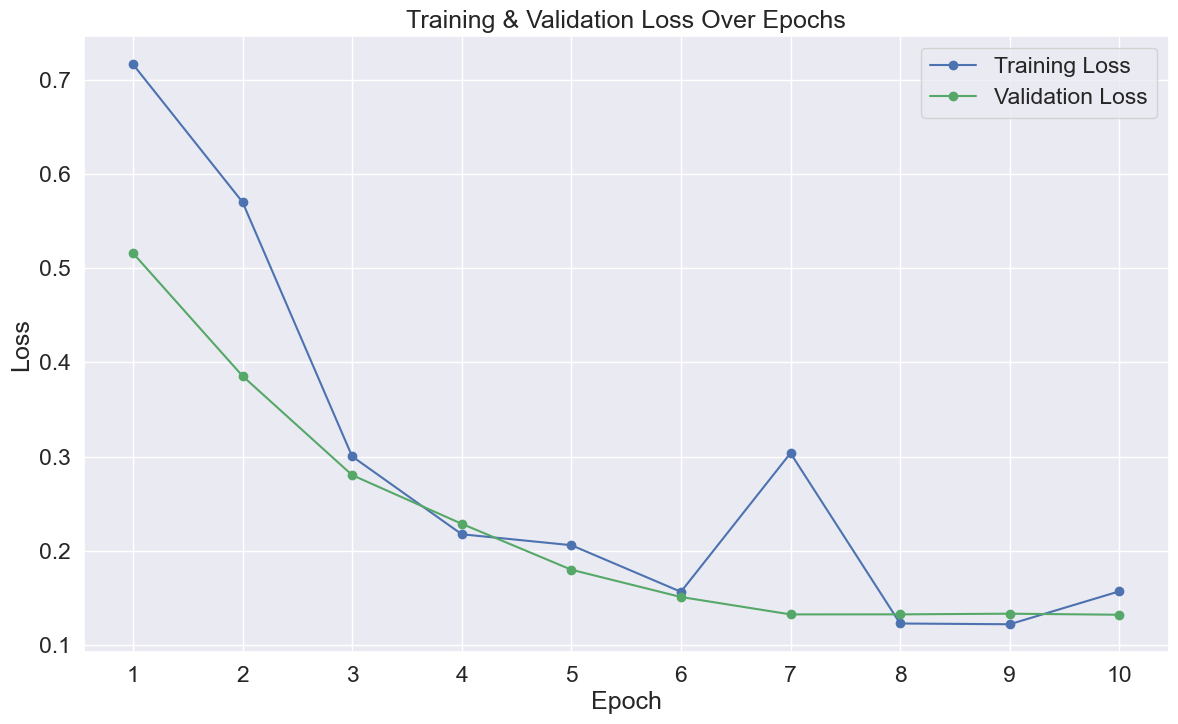

In [44]:
# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (14, 8)

# Plot the learning curve
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")

# Add titles and labels
plt.title("Training & Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(df_stats.index)

# Display the plot
plt.show()

In [45]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# Display the total number of named parameters in the model.
print(f'The GPT-2 model has {len(params)} different named parameters.\n')

# Define a helper function to print parameter names and their sizes.
def print_params(params, start_idx, end_idx, section_name):
    print(f'\n==== {section_name} ====\n')
    for p in params[start_idx:end_idx]:
        print(f"{p[0]:<55} {str(tuple(p[1].size())):>12}")

# Print parameters in the embedding layer.
print_params(params, 0, 2, 'Embedding Layer')

# Print parameters in the first transformer block.
print_params(params, 2, 14, 'First Transformer')

# Print parameters in the output layer.
print_params(params, -2, None, 'Output Layer')

The GPT-2 model has 148 different named parameters.


==== Embedding Layer ====

transformer.wte.weight                                  (50258, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (307

#### Text Generator

In [46]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# Load the pre-trained model and tokenizer for Question-Answering
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Load the questions from the CSV file
df = pd.read_csv("Data/last_50_QA_clean.csv")

# Define the question number
N = 105

# Fetch the question and context from the dataframe
question = df['Q'].iloc[N]
context = df['A'].iloc[N]

# Tokenize the input
inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

# Get the most likely beginning and end of the answer span
start_index = torch.argmax(start_scores)
end_index = torch.argmax(end_scores) + 1

# Decode the tokens to get the answer
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0][start_index:end_index]))

print('\n\n')
print(f"Question: {df['Q'][N]}")
print(f"Answer: {df['A'][N]}")
print('\n')
print(f"Generated Answer: {answer}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pradip\.cache\huggingface\hub\models--distilbert-base-cased-distilled-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\huggingface

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      




Question: Which areas does SUNation Energy continue to serve?
Answer: Long Island, Queens, Brooklyn and Staten Island


Generated Answer: Long Island, Queens, Brooklyn and Staten Island


In [47]:
df.head()

,Unnamed: 0,summary,Q,A
0,0,"Anza, a solar and energy storage procurement p...",What is the name of the solar and energy stora...,Anza
1,1,"Anza, a solar and energy storage procurement p...",What does Anza's technology provide?,analytics
2,2,Solar solutions provider Nextracker is set to ...,Which solar solutions provider is set to launc...,Nextracker
3,3,Solar solutions provider Nextracker is set to ...,How much faster can NX Horizon stow than stand...,four times faster
4,4,Solar solutions provider Nextracker is set to ...,What is Nextracker's latest innovation for hil...,NX Horizon XTR-1.5


In [48]:
# Load the pre-trained model and tokenizer for Question-Answering
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Load the questions from the CSV file
df = pd.read_csv("Data/last_50_QA_clean.csv")

# Function to extract answers using the QA model
def extract_answer(question, context):
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_scores = outputs.start_logits
        end_scores = outputs.end_logits

    start_index = torch.argmax(start_scores)
    end_index = torch.argmax(end_scores) + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0][start_index:end_index]))
    return answer

# List to store the answers
fine_tune_answer = []

# Iterate over each question and context pair in the DataFrame
for N, Q in enumerate(df['Q']):
    question = Q
    context = df['A'][N]
    
    # Extract the answer
    answer = extract_answer(question, context)
    
    # Append the answer to the list
    fine_tune_answer.append(answer)

# Print the results
for i, answer in enumerate(fine_tune_answer):
    print(f"Question: {df['Q'][i]}")
    print(f"Context: {df['A'][i]}")
    print(f"Generated Answer: {answer}")
    print('\n')


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

Question: What is the name of the solar and energy storage procurement platform?
Context: Anza
Generated Answer: Anza


Question: What does Anza's technology provide?
Context: analytics
Generated Answer: analytics


Question: Which solar solutions provider is set to launch a suite of next-generation innovations?
Context: Nextracker
Generated Answer: Nextracker


Question: How much faster can NX Horizon stow than standard trackers?
Context: four times faster
Generated Answer: four times


Question: What is Nextracker's latest innovation for hilly sites?
Context: NX Horizon XTR-1.5
Generated Answer: NX Horizon XTR - 1. 5


Question: What does Nextracker capture and analyze to help professionals stay current and navigate the solar market?
Context: raw materials
Generated Answer: raw materials


Question: What is the name of the DC optimizer company that focuses on large-scale photovoltaic systems?
Context: Ampt
Generated Answer: Ampt


Question: What is the output power of the i50 String 

In [49]:
# adding the fine_tune_answer
df['fine_tuned_answer'] = fine_tune_answer
df

,Unnamed: 0,summary,Q,A,fine_tuned_answer
0,0,"Anza, a solar and energy storage procurement p...",What is the name of the solar and energy stora...,Anza,Anza
1,1,"Anza, a solar and energy storage procurement p...",What does Anza's technology provide?,analytics,analytics
2,2,Solar solutions provider Nextracker is set to ...,Which solar solutions provider is set to launc...,Nextracker,Nextracker
3,3,Solar solutions provider Nextracker is set to ...,How much faster can NX Horizon stow than stand...,four times faster,four times
4,4,Solar solutions provider Nextracker is set to ...,What is Nextracker's latest innovation for hil...,NX Horizon XTR-1.5,NX Horizon XTR - 1. 5
...,...,...,...,...,...
187,187,Once the self-proclaimed “ leading renewable p...,What may serve as a cautionary tale for the in...,rapid rise and fall,rapid rise and fall
188,188,Arevon Energy Inc. has closed financing on the...,Who closed financing on the Vikings solar-plus...,Arevon Energy Inc.,Arevon Energy Inc
189,189,Arevon Energy Inc. has closed financing on the...,Who participated as a lender on the Vikings so...,National Bank of Canada,National Bank of Canada
190,190,Arevon Energy Inc. has closed financing on the...,Which company is supplying the Vikings solar-p...,Tesla,Tesla


In [51]:
from pinecone import Pinecone, ServerlessSpec

# use the api
pc = Pinecone(api_key='cff3b665-1409-4774-bb88-d2d9ce67286f')
index_name = 'clt-trials'

index = pc.Index(index_name)
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'last_50': {'vector_count': 50}},
 'total_vector_count': 50}

In [52]:
# Load the SentenceTransformer model
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

# Read the DataFrame from the CSV file
df1 = pd.read_csv("Data/last_50_QA.csv", index_col=0)

# Define the function to clean the text
def clean_text_list(txt):
    txt_list = txt[2:].split("', '")
    return [txt.strip(' ') for txt in txt_list]

# Initialize lists to store embeddings and original text
embedding_list = []
original_dict = {}

# Iterate over each key sentence in the DataFrame
for i, txt in enumerate(df1['key_sentences']):
    # Clean and split the text
    sentences = clean_text_list(txt)
    
    # Encode each sentence and store its embedding along with original text
    for j, s in enumerate(sentences):
        s_id = f'{i}_{j}'
        s_embedding = model.encode(s)
        original_dict[s_id] = s
        embedding_list.append({"id": s_id, "values": s_embedding.tolist()})

print(len(embedding_list))


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pradip\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

50


### UPSERT Operation to PIPECONE

In [53]:
# Initialize the SentenceTransformer model
se = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

# Read the dataframe
df1 = pd.read_csv("Data/last_50_QA.csv", index_col=0)

# Define the function to clean the text
def clean_text_list(txt):
    txt_list = txt[2:].split("', '")
    return [txt.strip(' ') for txt in txt_list]

# Encode and insert vectors
embedding_list = []
original_dict = {}
for i, txt in enumerate(df1['key_sentences']):
    for j, s in enumerate(clean_text_list(txt)):
        s_id = f'{i}_{j}'
        s_value = se.encode(s).tolist()
        original_dict[s_id] = s
        embedding_list.append(
            {"id": s_id, "values": s_value}
        )

# Ensure that each vector has dimensionality of 390
for embedding in embedding_list:
    embedding["values"] = embedding["values"][:390]

# Upsert vectors into the index
ns = "last_50"
index.upsert(
    vectors=embedding_list,
    namespace=ns
)


C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'upserted_count': 50}

In [54]:
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'last_50': {'vector_count': 50}},
 'total_vector_count': 50}

In [55]:
def get_context(index, question, top_k):
    # Generate embeddings for the question
    xq = se.encode(question).tolist()
    # Search Pinecone index for context passage with the answer
    xc = index.query(
        namespace=ns,
        vector=se.encode(question).tolist(),
        top_k=top_k,
        include_values=False
    )
    # Extract the context passages from Pinecone search result
    return xc["matches"]


In [56]:
# Assuming you have a CSV file named 'data.csv' containing columns 'Q' and 'A'
df = pd.read_csv("Data/last_50_QA_clean.csv", index_col=0)

# Now you can access the DataFrame using df[['Q', 'A']].iloc[90]
print(df[['Q', 'A']].iloc[90])


Q    What types of storage solutions will be used i...
A    intraday (10 to 36 hours) and multiday (36 to ...
Name: 90, dtype: object


In [57]:
# set the question and query the from the embedding database

question = "Where is the Allen S. King plant located?"
context_list = get_context(index, question, top_k=5)

context_list

[{'id': '47_0', 'score': 0.269132495, 'values': []},
 {'id': '39_0', 'score': 0.249461159, 'values': []},
 {'id': '32_0', 'score': 0.232970178, 'values': []},
 {'id': '9_0', 'score': 0.209610879, 'values': []},
 {'id': '27_0', 'score': 0.192504242, 'values': []}]

### Answering for Questions from Pipeline

In [ ]:
question_answerer = pipeline("question-answering")

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

C:\Users\Pradip\switchdrive\HSLU\_Sem 4\CTL\venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pradip\.cache\huggingface\hub\models--distilbert--distilbert-base-cased-distilled-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

In [ ]:
# Check the results
for context in context_list:
    context_text = original_dict[context['id']]
    qa_result = question_answerer(question=question, context=context_text)
    print()
    print(f"Embedding score: {context['score']}")
    print(f"Answer: '{qa_result['answer']}', score: {round(qa_result['score'], 4)}, start: {qa_result['start']}, end: {qa_result['end']}")


In [ ]:
# Find the context with the highest embedding score
highest_score_context = max(context_list, key=lambda x: x['score'])
highest_score_context_text = original_dict[highest_score_context['id']]

# Get the QA result for the context with the highest score
highest_score_qa_result = question_answerer(question=question, context=highest_score_context_text)

# Print the QA result for the context with the highest score
print(f"Highest Embedding Score: {highest_score_context['score']}")
print(f"Answer: '{highest_score_qa_result['answer']}', Score: {round(highest_score_qa_result['score'], 4)}, Start: {highest_score_qa_result['start']}, End: {highest_score_qa_result['end']}")
